In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
train_new_df = pd.read_csv('/content/train_new.csv')
train_df = pd.read_csv('/content/train.csv')
oil_df = pd.read_csv('/content/oil.csv')
store_df = pd.read_csv('/content/stores.csv')
holiday_events_df = pd.read_csv('/content/holidays_events.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission_df = pd.read_csv('/content/sample_submission.csv')
transactions_df = pd.read_csv('/content/transactions.csv')

In [ ]:
# Load the dataset
dataframe = pd.read_csv('/content/train_new.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [ ]:
# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

In [ ]:
# Function to create sequences for LSTM
def create_sequences(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_forward + 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Create sequences for training and testing
look_back = 3  # You can adjust this parameter based on your problem
look_forward = 1  # Number of steps to predict into the future
X, Y = create_sequences(dataset_scaled, look_back, look_forward)

In [ ]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

4/4 [==============================] - 1s 6ms/step
Mean Squared Error for fold: 4.432247638702393
1/1 [==============================] - 0s 22ms/step


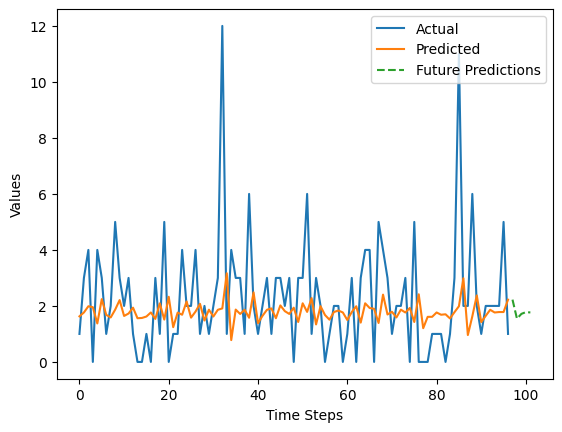

4/4 [==============================] - 0s 5ms/step
Mean Squared Error for fold: 4.432247638702393
1/1 [==============================] - 0s 23ms/step


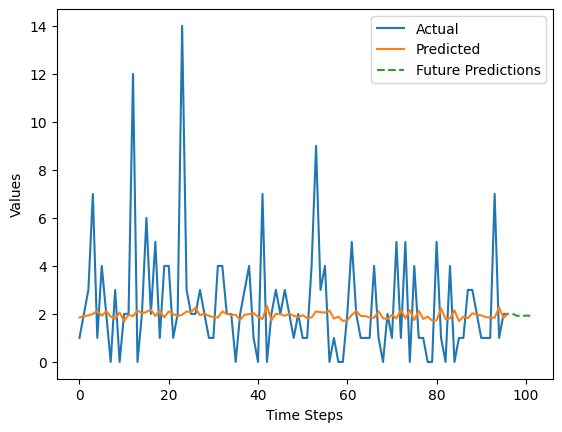

4/4 [==============================] - 1s 6ms/step
Mean Squared Error for fold: 4.432247638702393
1/1 [==============================] - 0s 33ms/step


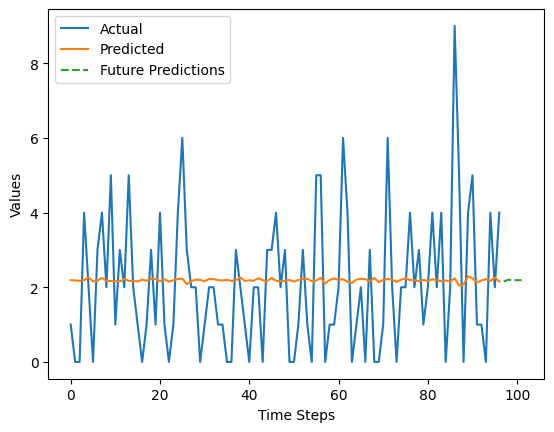

4/4 [==============================] - 0s 5ms/step
Mean Squared Error for fold: 4.432247638702393
1/1 [==============================] - 0s 22ms/step


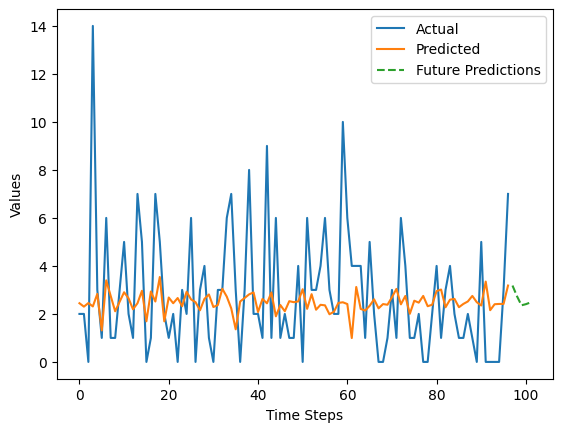

4/4 [==============================] - 1s 5ms/step
Mean Squared Error for fold: 4.432247638702393
1/1 [==============================] - 0s 27ms/step


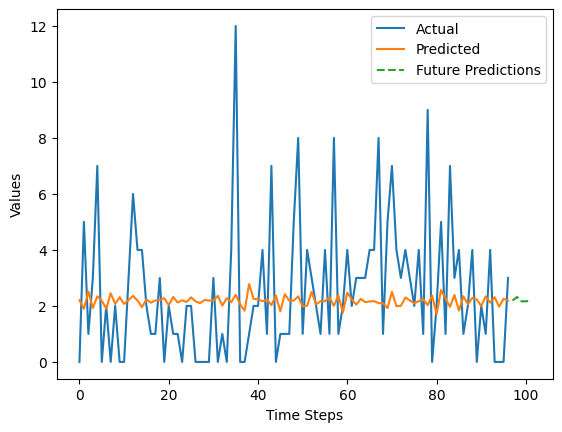

In [ ]:
# Perform Time Series Cross Validation
for train_index, test_index in tscv.split(X):
    # Split the data into train and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Reshape the input data to be 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(look_forward))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)

    # Make predictions
    predictions = model.predict(X_test)
    print(f'Mean Squared Error for fold: {mse}')

    # Invert the scaling back to original values
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, look_forward))

    # Plot actual vs predicted values
    plt.plot(y_test.flatten(), label='Actual')
    plt.plot(predictions.flatten(), label='Predicted')

    # Predict the future values for a given test sequence
    future_steps = 5  # Adjust this based on how many steps into the future you want to predict
    last_sequence = X_test[-1].reshape((1, look_back, 1))
    future_predictions = []

    for _ in range(future_steps):
        next_step = model.predict(last_sequence)
        future_predictions.append(next_step)
        last_sequence = np.concatenate((last_sequence[:, 1:, :], next_step.reshape((1, look_forward, 1))), axis=1)

    # Invert the scaling for future predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, look_forward))

    # Plot future predictions
    future_indices = range(len(y_test), len(y_test) + future_steps)
    plt.plot(future_indices, future_predictions.flatten(), label='Future Predictions', linestyle='dashed')

    # Display the plot
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()